In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy
from collections import defaultdict, Counter
import datetime

from upsetplot import from_contents,plot
import matplotlib.pyplot as plt


In [2]:
print(os.getcwd())
sys.path.insert(0, str(os.path.dirname(os.path.realpath(os.getcwd()))))
print(sys.path)

/mnt/f/dev/git/miRExplore/python/nbs
['/mnt/f/dev/git/miRExplore/python', '/mnt/f/dev/git/miRExplore/python/nbs', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/mjoppich/.local/lib/python3.8/site-packages', '/home/mjoppich/.local/lib/python3.8/site-packages/pIMZ-1.0-py3.8-linux-x86_64.egg', '/home/mjoppich/.local/lib/python3.8/site-packages/progressbar-2.5-py3.8.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/mpld3-0.3.1.dev1-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython']


In [3]:
%autoreload 2
from textdb.PubmedDateDB import PubmedDateDB
%autoreload 2
from synonymes.mirnaID import miRNA, miRNAPART
%autoreload 2
from textdb.MiGenRelDB import MiGenRelDB,MiRGeneRel
%autoreload 2
from synonymes.GeneOntology import GeneOntology
%autoreload 2
from textdb.PMID2XDB import PMID2XDB
from textdb.PMID2PMCDB import PMID2PMCDB
from textdb.MirTarBaseDB import MirTarBaseDB
from analysis.miRecordDB import miRecordDB
from textdb.DIANATarbaseDB import DIANATarbaseDB


In [4]:
pmidBase ="/mnt/f/dev/data/pmid_jun2020/aggregated_pmid/"
pmcBase ="/mnt/f/dev/data/pmid_jun2020/aggregated_pmc/"
obodir = "/mnt/f/dev/data/pmid_jun2020/obodir/"

fileDir = os.path.dirname(os.path.realpath(os.getcwd()))

In [5]:
from utils.tmutils import normalize_gene_names
normGeneSymbols = normalize_gene_names(path="/mnt/d/owncloud/data/miRExplore/obodir/" + "/hgnc_no_withdrawn.syn")

In [6]:
pmid2pmcDB = PMID2PMCDB.loadFromFile(pmcBase + '/pmc2pmid', PMC2PMID=True)
excludePMIDs = pmid2pmcDB.getAllPMIDs()
excludePMCs = pmid2pmcDB.getAllPMCs()

In [7]:
print("Loading hsa")
mirelPMIDhsa = MiGenRelDB.loadFromFile(pmidBase + "/mirna_gene.hsa.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)
print("Loading mmu")
mirelPMIDmmu = MiGenRelDB.loadFromFile(pmidBase + "/mirna_gene.mmu.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)

print("Loading hsa")
mirelPMChsa = MiGenRelDB.loadFromFile(pmcBase + "/mirna_gene.hsa.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)
print("Loading mmu")
mirelPMCmmu = MiGenRelDB.loadFromFile(pmcBase + "/mirna_gene.mmu.pmid", ltype="mirna", rtype="gene", normGeneSymbols=normGeneSymbols, switchLR=True, stopAfter=-1)



relDBs = [mirelPMIDhsa, mirelPMIDmmu, mirelPMChsa, mirelPMCmmu]

Loading hsa
Gene Symbols Normalized 77586
Loaded file /mnt/f/dev/data/pmid_jun2020/aggregated_pmid//mirna_gene.hsa.pmid
Accepted Doc IDs 40616
Rejected Doc IDs 0
Seen genes 7895
Seen miRNAs 2086
Seen Harm. miRNAs 1606
Loading mmu
Gene Symbols Normalized 12789
Loaded file /mnt/f/dev/data/pmid_jun2020/aggregated_pmid//mirna_gene.mmu.pmid
Accepted Doc IDs 36864
Rejected Doc IDs 0
Seen genes 6379
Seen miRNAs 2015
Seen Harm. miRNAs 1565
Loading hsa
Gene Symbols Normalized 104649
Loaded file /mnt/f/dev/data/pmid_jun2020/aggregated_pmc//mirna_gene.hsa.pmid
Accepted Doc IDs 10749
Rejected Doc IDs 0
Seen genes 6911
Seen miRNAs 1868
Seen Harm. miRNAs 1312
Loading mmu
Gene Symbols Normalized 23456
Loaded file /mnt/f/dev/data/pmid_jun2020/aggregated_pmc//mirna_gene.mmu.pmid
Accepted Doc IDs 10647
Rejected Doc IDs 0
Seen genes 6056
Seen miRNAs 1872
Seen Harm. miRNAs 1323


In [8]:
sourceCompLevel = [miRNAPART.MATURE, miRNAPART.ID] #, miRNAPART.PRECURSOR

In [9]:
recordsDB = miRecordDB.loadFromFile(filelocation=fileDir + "/dbs/mirecords_v4.xlsx", normGeneSymbols=normGeneSymbols)
mirtarbaseDB = MirTarBaseDB.loadFromFile(filepath=fileDir + "/dbs/miRTarBase.csv", normGeneSymbols=normGeneSymbols)
dianaDB, celllInfos = DIANATarbaseDB.loadFromFile(fileDir + "/dbs/hsa_mmu.diana.csv", normGeneSymbols=normGeneSymbols)


/mnt/f/dev/git/miRExplore/python/dbs/mirecords_v4.xlsx
new
SMAD1 GARS
SMAD1 GARS
SMAD5 SMAD5
SMAD1 GARS
SMAD1 GARS
SMAD5 SMAD5
SMAD5 SMAD5
SMAD1 GARS
SMAD1 GARS
SMAD3 SMAD3
SMAD2 SMAD2
SMAD3 SMAD3
SMAD 4 SMAD4
SMAD 5 SMAD5
SMAD3 SMAD3
SMAD 4 SMAD4
SMAD 5 SMAD5
SMAD3 SMAD3
SMAD 4 SMAD4
SMAD 5 SMAD5
Gene Symbols Normalized 280
Gene Symbols Normalized 0


In [10]:
tmInteractions = set()

for rdb in relDBs:

    for gene in rdb.ltype2rel:

        for rel in rdb.ltype2rel[gene]:

            mirObj = miRNA(rel.rid)

            #fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
            baseMirna = mirObj.getStringFromParts(sourceCompLevel)
            intTuple = (rel.lid, baseMirna)

            tmInteractions.add(intTuple)

In [11]:
mirecordsInteractions = set()

for gene in recordsDB.ltype2rel:

    for rel in recordsDB.ltype2rel[gene]:

        mirObj = miRNA(rel.rid)

        #fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
        baseMirna = mirObj.getStringFromParts(sourceCompLevel)
        intTuple = (rel.lid, baseMirna)

        mirecordsInteractions.add(intTuple)

In [12]:

mirtarbaseInteractions = set()

for gene in mirtarbaseDB.ltype2rel:

    for rel in mirtarbaseDB.ltype2rel[gene]:

        mirObj = miRNA(rel.rid)

        #fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
        baseMirna = mirObj.getStringFromParts(sourceCompLevel)
        intTuple = (rel.lid, baseMirna)

        mirtarbaseInteractions.add(intTuple)

In [13]:

dianaInteractions = set()

for gene in dianaDB.ltype2rel:

    for rel in dianaDB.ltype2rel[gene]:

        mirObj = miRNA(rel.rid)

        #fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
        baseMirna = mirObj.getStringFromParts( sourceCompLevel )
        intTuple = (rel.lid, baseMirna)

        dianaInteractions.add(intTuple)

In [14]:
print(list(tmInteractions)[:4])
print(list(mirecordsInteractions)[:4])
print(list(mirtarbaseInteractions)[:4])
print(list(dianaInteractions)[:4])

[('VIM', 'miR-450'), ('CD44', 'miR-135'), ('GKN2', 'miR-1963'), ('CXCL12', 'miR-342')]
[('PPARA', 'miR-21'), ('BMPR2', 'miR-21'), ('VEGFA', 'miR-15'), ('PLSCR3', 'miR-124')]
[('ZNF770', 'miR-3664'), ('TMTC1', 'miR-3689'), ('PDZD4', 'miR-6869'), ('TOGARAM2', 'miR-296')]
[('KDM4C', 'miR-20'), ('FMR1', 'miR-34'), ('PLEKHA1', 'miR-1304'), ('JMY', 'miR-627')]


In [15]:
source2interactions = {}
source2interactions["tm"] = tmInteractions
source2interactions["miRecords"] = mirecordsInteractions
source2interactions["miRTarBase"] = mirtarbaseInteractions
source2interactions["DIANA-TarBase"] = dianaInteractions

In [16]:
printed = 0
for x in tmInteractions:
    
    if not x in source2interactions["miRecords"]:
        if not x in source2interactions["miRTarBase"]:
            if not x in source2interactions["DIANA-TarBase"]:
                
                print(x)
                printed += 1
                
                if printed > 5:
                    break
    

('CD44', 'miR-135')
('GKN2', 'miR-1963')
('CXCL12', 'miR-342')
('XRCC1', 'miR-138')
('CAPN3', 'miR-206')
('XIST', 'miR-367')


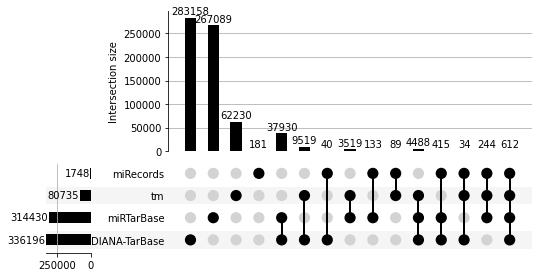

In [17]:
upIn = from_contents(source2interactions)
plot(upIn, subset_size="auto", show_counts =True)
plt.savefig("database_overlap_withpmc.png")

In [18]:
miRNAGenePMIDs = set()
for rdb in relDBs:
    for rpmid in rdb.get_evidence_docids():
        miRNAGenePMIDs.add(rpmid)

In [19]:
len(miRNAGenePMIDs)

44618

In [36]:
diseaseObo = GeneOntology(obodir + "/doid.obo")

#{'group': 'disease', 'termid': 'DOID:1936', 'name': 'atherosclerosis'}
#{'group': 'disease', 'termid': 'DOID:2349', 'name': 'arteriosclerosis'}
#{'group': 'disease', 'termid': 'DOID:1287', 'name': 'cardiovascular system disease'},
elemTerm = diseaseObo['DOID:1936']
elemTerms = [x.term.id for x in elemTerm.getAllChildren()] + [elemTerm.id]

cvTerm = diseaseObo['DOID:1287']
cvTerms = [x.term.id for x in cvTerm.getAllChildren()] + [cvTerm.id] + elemTerms

pmid2disease = PMID2XDB.loadFromFile(pmidBase + "/disease.pmid", diseaseObo, miRNAGenePMIDs)
pmc2disease = PMID2XDB.loadFromFile(pmcBase + "/disease.pmid", diseaseObo, miRNAGenePMIDs)

pmid2disease.add_database(pmc2disease)

0
10000
no parent 2382


In [21]:
# number of genes with interaction
allGenes = set()

for rdb in relDBs:
    allGenes = allGenes.union(set(rdb.all_ltypes))

print("Number of genes with interaction", len(allGenes))

Number of genes with interaction 8674


In [22]:
# number of miRNAs with interaction
## restrict to miR-x
allMirnas = set()
for rdb in relDBs:
    for mirna in rdb.all_rtypes:

        try:
            mirObj = miRNA(mirna)
            allMirnas.add(mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR]))

        except:

            print(mirna)
            exit(-1)

print("Number of mirnas with interaction", len(allMirnas))
print("DO NOT USE THIS NUMBER!!!!")

Number of mirnas with interaction 1296
DO NOT USE THIS NUMBER!!!!


In [23]:
for rdb in relDBs:
    for midx, mirna in enumerate(rdb.all_rtypes):
        print(mirna, type(mirna))
        
        if midx > 7:
            break
    

miR-130a <class 'str'>
miR-4775 <class 'str'>
miR-300-mediated <class 'str'>
miR-147a <class 'str'>
miR-101-2 <class 'str'>
miR-29c <class 'str'>
miR-499a <class 'str'>
miR-4421 <class 'str'>
miR-642a <class 'str'>
miR-130a <class 'str'>
miR-4775 <class 'str'>
miR-300-mediated <class 'str'>
miR-147a <class 'str'>
miR-101-2 <class 'str'>
miR-29c <class 'str'>
miR-499a <class 'str'>
miR-4421 <class 'str'>
miR-642a <class 'str'>
miR-518b <class 'str'>
miR-130a <class 'str'>
miR-411 <class 'str'>
miR-3149 <class 'str'>
miR-124-mediated <class 'str'>
miR-3150a <class 'str'>
miR-1843 <class 'str'>
miR-4775 <class 'str'>
miR-128-1-mediated <class 'str'>
miR-518b <class 'str'>
miR-130a <class 'str'>
miR-411 <class 'str'>
miR-3149 <class 'str'>
miR-124-mediated <class 'str'>
miR-3150a <class 'str'>
miR-1843 <class 'str'>
miR-25-mediated <class 'str'>
miR-4487 <class 'str'>


In [30]:
seenFullMirs = set()
seenShortMirs = set()

for rdb in relDBs:

    for gidx, gene in enumerate(rdb.ltype2rel):

        for rel in rdb.ltype2rel[gene]:
            
            
            mirstr = rel.orig_names[1]
            mirstr = rel.rid
            
            #if not rel.rid in mirstr:
            #    print(rel)
            #    print(rel.orig_names)
            
            #assert(rel.rid in mirstr)
            
            omir = miRNA(mirstr)
            fullMirna = omir.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
            shortMirna = omir.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR])
            
            #print(mirstr, fullMirna)
            
            seenFullMirs.add(fullMirna)
            seenShortMirs.add(shortMirna)

            
print("Short miRNAs", len(seenShortMirs))
print("Full miRNAs", len(seenFullMirs))

Short miRNAs 1296
Full miRNAs 1740


In [31]:
pmid2interactions = defaultdict(set)

for rdb in [mirelPMIDhsa, mirelPMIDmmu]:

    for gene in rdb.ltype2rel:

        for rel in rdb.ltype2rel[gene]:

            mirObj = miRNA(rel.rid)

            fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
            baseMirna = mirObj.getStringFromParts(sourceCompLevel)
            
            pmid2interactions[rel.docid].add( (rel.lid, baseMirna) )
            pmid2interactions[rel.docid].add( (rel.lid, fullMirna) )

In [32]:


def calculateStatistics(relDBs, filter=None):

    interactionsWithDisease = set()

    interactionsWithAthero = set()
    atheroPubmeds = set()
    cvPubmeds = set()
    allPubmeds = set()

    interactionsWithCV = set()
    totalMirnas = set()
    totalMirnasFull = set()
    totalGenes = set()

    totalInteractions = set()
    
    interactionByRegDir = defaultdict(set)

    for rdb in relDBs:

        for gene in rdb.ltype2rel:

            for rel in rdb.ltype2rel[gene]:

                #print(rel)
                #assert(1==0)


                if filter != None:
                    
                    if filter(rel):
                        continue

                
                        
                mirObj = miRNA(rel.rid)
                
                fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
                totalMirnasFull.add(fullMirna)

                baseMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR])
                intTuple = (rel.lid, baseMirna)

                totalInteractions.add(intTuple)
                
                interactionByRegDir[(rel.assocInt, rel.assocCat)].add(intTuple)
                
                totalMirnas.add(intTuple[1])
                totalGenes.add(intTuple[0])

                docID = rel.docid
                retVal = pmid2disease.getDOC(docID)

                allPubmeds.add(docID)

                if retVal != None:


                    interactionsWithDisease.add(intTuple)

                    for docDisease in retVal:

                        if docDisease['termid'] in elemTerms:
                            interactionsWithAthero.add(intTuple)
                            atheroPubmeds.add(docID)

                        if docDisease['termid'] in cvTerms:
                            interactionsWithCV.add(intTuple)
                            cvPubmeds.add(docID)
                            
    print("Different miRNAs", len(totalMirnas))
    print("Different miRNAs (full)", len(totalMirnasFull))
    print("Different genes", len(totalGenes))

    print("total Interactions", len(totalInteractions))
    print("total mirnas in interactions", len(set([x[1] for x in totalInteractions])))


    print("total interactions with disease", len(interactionsWithDisease))
    print("total mirnas in interactions with disease", len(set([x[1] for x in interactionsWithDisease])))

    atheroMirnas = set([x[1] for x in interactionsWithAthero])
    atheroGenes = set([x[0] for x in interactionsWithAthero])

    print("total interactions with athero", len(interactionsWithAthero))
    print("total mirnas in interactions with athero", len(atheroMirnas))
    print("total genes in interactions with athero", len(atheroGenes))
    print("total pubmeds for interactions with athero", len(atheroPubmeds))
    print("total pubmeds for interactions with cv", len(cvPubmeds))
    print("total pubmeds for interactions", len(allPubmeds))

    print("total interactions with cv", len(interactionsWithCV))
    print("total mirnas in interactions with cv", len(set([x[1] for x in interactionsWithCV])))
    
    print()
    
    for x in sorted(interactionByRegDir):
        print(x, len(interactionByRegDir[x]))

In [33]:
calculateStatistics(relDBs = [mirelPMIDhsa, mirelPMIDmmu])

Different miRNAs 1096
Different miRNAs (full) 1470
Different genes 6932
total Interactions 53791
total mirnas in interactions 1096
total interactions with disease 42725
total mirnas in interactions with disease 996
total interactions with athero 1046
total mirnas in interactions with athero 155
total genes in interactions with athero 473
total pubmeds for interactions with athero 396
total pubmeds for interactions with cv 2529
total pubmeds for interactions 34466
total interactions with cv 5743
total mirnas in interactions with cv 417

('GENE_MIR', 'DOWN') 5070
('GENE_MIR', 'NEU') 12684
('GENE_MIR', 'UP') 4600
('MIR_GENE', 'CHNAGE') 4
('MIR_GENE', 'DOWN') 23936
('MIR_GENE', 'NEU') 32585
('MIR_GENE', 'UP') 10650


In [37]:
calculateStatistics(relDBs = [mirelPMChsa, mirelPMCmmu])

Different miRNAs 979
Different miRNAs (full) 1257
Different genes 6256
total Interactions 54499
total mirnas in interactions 979
total interactions with disease 53405
total mirnas in interactions with disease 965
total interactions with athero 8714
total mirnas in interactions with athero 442
total genes in interactions with athero 1930
total pubmeds for interactions with athero 869
total pubmeds for interactions with cv 2997
total pubmeds for interactions 10152
total interactions with cv 21317
total mirnas in interactions with cv 650

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 7278
('GENE_MIR', 'NEU') 16792
('GENE_MIR', 'UP') 7824
('MIR_GENE', 'DOWN') 18501
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 34514
('MIR_GENE', 'UP') 12512


In [38]:
def filterFunc(rel):
    relDocID = rel.docid
    
    relDocPMID = pmid2pmcDB.pmc2pmid.get(relDocID, None)
    
    if relDocPMID == None:
        # no abstract existing for PMC
        return False
    
    mirObj = miRNA(rel.rid)

    fullMirna = mirObj.getStringFromParts([miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR, miRNAPART.MATURE_SEQS, miRNAPART.ARM])
    baseMirna = mirObj.getStringFromParts(sourceCompLevel)
    
    gene = rel.lid
    
    for pmid in relDocPMID:
        pmidInteractions = pmid2interactions[pmid]

        if (gene, fullMirna) in pmidInteractions:
            return True

        if (gene, baseMirna) in pmidInteractions:
            return True
    
    return False

# only additional PMC miRNA-gene hits
calculateStatistics(relDBs = [mirelPMChsa, mirelPMCmmu], filter=filterFunc)

Different miRNAs 973
Different miRNAs (full) 1225
Different genes 6172
total Interactions 53024
total mirnas in interactions 973
total interactions with disease 51958
total mirnas in interactions with disease 960
total interactions with athero 8609
total mirnas in interactions with athero 442
total genes in interactions with athero 1906
total pubmeds for interactions with athero 867
total pubmeds for interactions with cv 2990
total pubmeds for interactions 10116
total interactions with cv 20903
total mirnas in interactions with cv 649

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 6202
('GENE_MIR', 'NEU') 15242
('GENE_MIR', 'UP') 6868
('MIR_GENE', 'DOWN') 16999
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 33045
('MIR_GENE', 'UP') 11249


In [39]:
def filterFunc(rel):
    relOrgs = rel.orgs
    if relOrgs == None:
        relOrgs = set()

    if not ('mmu' in relOrgs or 'hsa' in relOrgs):
        return True
    
    return False

In [40]:
calculateStatistics(relDBs = [mirelPMIDhsa, mirelPMIDmmu, mirelPMChsa, mirelPMCmmu], filter=filterFunc)    

Different miRNAs 1159
Different miRNAs (full) 1526
Different genes 7545
total Interactions 72316
total mirnas in interactions 1159
total interactions with disease 67124
total mirnas in interactions with disease 1114
total interactions with athero 9129
total mirnas in interactions with athero 457
total genes in interactions with athero 2002
total pubmeds for interactions with athero 1102
total pubmeds for interactions with cv 4121
total pubmeds for interactions 25334
total interactions with cv 22989
total mirnas in interactions with cv 685

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 9168
('GENE_MIR', 'NEU') 21241
('GENE_MIR', 'UP') 9508
('MIR_GENE', 'DOWN') 27740
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 45340
('MIR_GENE', 'UP') 16552


In [41]:
calculateStatistics(relDBs = [mirelPMChsa, mirelPMCmmu], filter=filterFunc)

Different miRNAs 976
Different miRNAs (full) 1252
Different genes 6210
total Interactions 53942
total mirnas in interactions 976
total interactions with disease 52882
total mirnas in interactions with disease 962
total interactions with athero 8702
total mirnas in interactions with athero 442
total genes in interactions with athero 1927
total pubmeds for interactions with athero 863
total pubmeds for interactions with cv 2957
total pubmeds for interactions 9893
total interactions with cv 21231
total mirnas in interactions with cv 646

('GENE_MIR', 'CHNAGE') 2
('GENE_MIR', 'DOWN') 7233
('GENE_MIR', 'NEU') 16592
('GENE_MIR', 'UP') 7756
('MIR_GENE', 'DOWN') 18418
('MIR_GENE', 'NAN') 2
('MIR_GENE', 'NEU') 34079
('MIR_GENE', 'UP') 12414


In [ ]:
def filterFunc(rel):
    relOrgs = rel.orgs
    if relOrgs == None:
        relOrgs = set()

    if not ('mmu' in relOrgs or 'hsa' in relOrgs):
        return True
    
    return False